# Transfer Learn from InceptionV3

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import Input, GlobalAveragePooling2D, Dense
from keras import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv

sns.set_style("whitegrid")

In [2]:
# To avoid:
# StdErr from Kernel Process OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5 already initialized.
# OMP: Hint This means that multiple copies of the OpenMP runtime have been linked into the program.

import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## Load Training Data

In [3]:
def load_image(file_name):
    raw = tf.io.read_file(file_name)
    tensor = tf.io.decode_jpeg(raw, channels=3)
    tensor = tf.image.resize(tensor, [224, 224])
    tensor = tf.cast(tensor, tf.uint8)
    return tensor

def create_dataset(file_names, values):
    dataset = tf.data.Dataset.from_tensor_slices((file_names, values))
    dataset = dataset.map(lambda file_name, value: (load_image(file_name), value))
    return dataset

def configure_for_performance(dataset):
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=2040, reshuffle_each_iteration=True)
    dataset = dataset.batch(32)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

training_data = pd.read_csv("../data/ColorCast/training_data.csv")
file_names = training_data['File'].to_numpy()
values = training_data[["Red", "Green", "Blue"]].to_numpy()
train_dataset = create_dataset(file_names, values)
train_dataset = configure_for_performance(train_dataset)

## Define Network Architecture

In [4]:
base_model = InceptionV3(input_tensor=Input(shape=(224, 224, 3)),
                         weights='imagenet',
                         include_top=False)

base_model.trainable = False
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [5]:
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(units=3)

In [6]:
inputs = Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [7]:
optimizer = Adam(learning_rate=0.01)
loss = tf.keras.losses.MeanSquaredError()
metrics = tf.keras.metrics.RootMeanSquaredError()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Train the network

In [36]:
history = model.fit(train_dataset, epochs=1000)

Epoch 1/1000
64/64 [==============================] - 11s 66ms/step - loss: 522.5214 - root_mean_squared_error: 22.8587
Epoch 2/1000
64/64 [==============================] - 4s 65ms/step - loss: 404.1717 - root_mean_squared_error: 20.1040
Epoch 3/1000
64/64 [==============================] - 4s 65ms/step - loss: 343.1956 - root_mean_squared_error: 18.5255
Epoch 4/1000
64/64 [==============================] - 4s 65ms/step - loss: 308.3094 - root_mean_squared_error: 17.5587
Epoch 5/1000
64/64 [==============================] - 4s 67ms/step - loss: 279.6515 - root_mean_squared_error: 16.7228
Epoch 6/1000
64/64 [==============================] - 4s 65ms/step - loss: 263.0601 - root_mean_squared_error: 16.2191
Epoch 7/1000
64/64 [==============================] - 4s 66ms/step - loss: 239.6907 - root_mean_squared_error: 15.4819
Epoch 8/1000
64/64 [==============================] - 4s 68ms/step - loss: 232.5428 - root_mean_squared_error: 15.2494
Epoch 9/1000
64/64 [===========================

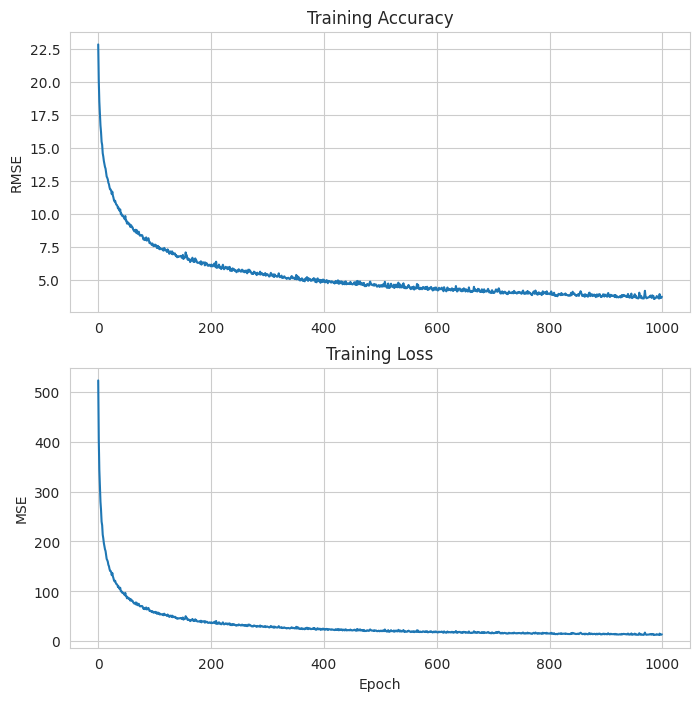

In [37]:
acc = history.history['root_mean_squared_error']
loss = history.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc)
plt.ylabel('RMSE')
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.ylabel('MSE')
plt.title('Training Loss')
plt.xlabel('Epoch')

plt.show()

## Test the network

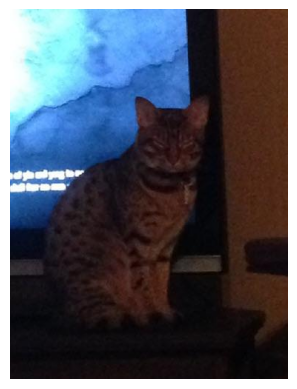

In [9]:
cat_image = cv.imread("../data/cat_dark.jpg")
cat_image = cv.cvtColor(cat_image, cv.COLOR_BGR2RGB)

plt.figure()
plt.imshow(cat_image)
plt.axis("off")
plt.show()

The displayed photo contains a cat, but it is hard to see because of the photo's lighting. Before we can use this image with the network, it must be resized to match InceptionV3 image input layer. InceptionV3 expects images sized [224 224].

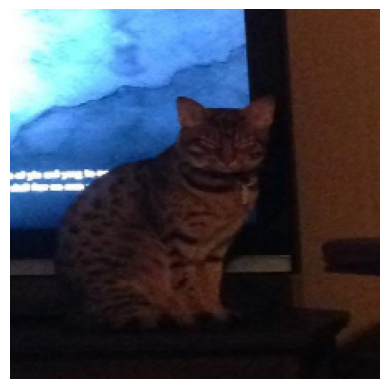

In [10]:
test_image = cv.resize(cat_image, (224, 224))

plt.figure()
plt.imshow(test_image)
plt.axis("off")
plt.show()

Convert the image to a tensor and pass it to the predict function.

In [11]:
test_image = tf.convert_to_tensor(test_image, dtype=tf.uint8)
test_image = tf.expand_dims(test_image, axis=0)

In [15]:
prediction = model.predict(test_image, verbose=False)
prediction

array([[ -21.205235, -110.09816 ,  -12.604358]], dtype=float32)

Fix the image according to the prediction.

In [16]:
fixed_image = cat_image.copy().astype(np.int16)
fixed_image[:, :, 0] = fixed_image[:, :, 0] - prediction[0][0].astype(np.int16)
fixed_image[:, :, 1] = fixed_image[:, :, 1] - prediction[0][1].astype(np.int16)
fixed_image[:, :, 2] = fixed_image[:, :, 2] - prediction[0][2].astype(np.int16)
fixed_image = np.clip(fixed_image, 0, 255)

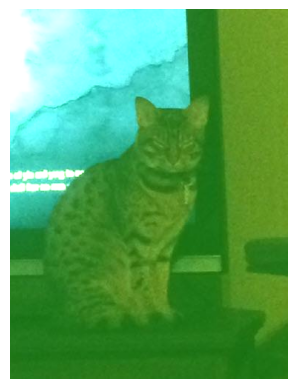

In [17]:
plt.figure()
plt.imshow(fixed_image)
plt.axis("off")
plt.show()

## Evaluate the network

In [18]:
test_data = pd.read_csv("../data/ColorCast/test_data.csv")
file_names = test_data['File'].to_numpy()
values = test_data[["Red", "Green", "Blue"]].to_numpy()
test_dataset = create_dataset(file_names, values)
test_dataset = configure_for_performance(test_dataset)

The predict function can accept an image dataset for the testing data.

In [19]:
predictions = model.predict(test_dataset, verbose=False)
predictions

array([[ 14.411007 ,  28.829721 , -25.798567 ],
       [-22.215319 ,  44.03142  , -25.979214 ],
       [-11.849445 ,  15.971934 ,  -4.4787703],
       [  3.9030948, -37.179707 ,  30.12705  ],
       [  7.410709 ,  31.848856 , -24.33484  ],
       [-33.59931  ,   2.963679 ,   3.729638 ],
       [ -1.1629496,   8.255883 , -27.707867 ],
       [ 46.87663  , -22.198637 ,  16.780588 ],
       [  3.0920062,  11.157655 ,  17.28588  ],
       [-25.487728 ,  11.467249 ,  14.545468 ],
       [ 11.37175  ,  23.575117 , -12.043658 ],
       [-53.388042 ,  25.12175  ,  -0.382805 ],
       [-20.34993  ,  -9.487325 ,  19.3506   ],
       [  8.32493  , -14.290715 , -13.358502 ],
       [ 30.465546 ,  23.718636 ,   6.9219146],
       [  1.7406783, -24.53045  ,  -8.245446 ],
       [ -5.091206 ,  46.10014  ,   0.0742581],
       [ 20.31585  ,  -1.8027241,  23.165615 ],
       [ 33.557602 , -18.66555  ,  16.147833 ],
       [ -1.6760793,  16.985613 , -25.863962 ]], dtype=float32)

Corresponding RGB response.

In [20]:
values

array([[  8, -13, -14],
       [ -1,  43,   5],
       [-15, -11,  24],
       [  7,  21, -11],
       [-51,  28,   6],
       [  4, -42,  28],
       [  0,  10, -22],
       [ 49, -22,  20],
       [ 19,  28, -19],
       [-21,  47, -23],
       [-28,   9,  19],
       [-36,  -4,   4],
       [-15,  11, -10],
       [  6,  29, -21],
       [ 27,  22,   2],
       [ 11,  10,  21],
       [ 33, -22,  18],
       [ 22,  -4,  27],
       [ -2, -27,  -9],
       [ -4,  15, -25]], dtype=int64)

We will calculate the root-mean-square error (RMSE) of the predicted RGB values. This is a common method for calculating accuracy of a regression network.

In [21]:
error = np.sqrt(np.square(np.subtract(values, predictions)).mean(axis=0))
error

array([22.7190038 , 30.58963614, 24.1157635 ])